# NY Person Trip Predictor

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import model_selection
import warnings
import math

warnings.filterwarnings('ignore')

In [2]:
path = "C:/Users/Seant/Desktop/aml_data" #edit this path to change to your path folder

#path = "/Users/jayneteo/Dropbox/SMU MITB/Term 2 2021/AML/Project/NHTS/csv" 

household = pd.read_csv("".join([path,'/hhpub.csv']))
person =  pd.read_csv("".join([path,'/perpub.csv']))
trip =  pd.read_csv("".join([path,'/trippub.csv']))

In [3]:
#define function 

def cat_col_prop(data, col):
    print(pd.concat([data[col].value_counts(),
          data[col].value_counts(normalize = True).mul(100)],axis = 1, keys = ('counts','percentage')))

    sns.countplot(data[col], order =  data[col].value_counts().index)

## 1. Merging of Data

### 1.1. Household

In [4]:
#filtering NY Households
ny = household[household['HHSTATE'] == "NY"]

# as only studying hh with car will also filter out hh with HHVEHCNT == 0
ny = ny[ny['HHVEHCNT']>0]

In [5]:
# selection of columns based on prior background inference of potential features
ny = ny[['HOUSEID','HH_CBSA','HOMEOWN','HHSIZE','HHVEHCNT','HHFAMINC','NUMADLT','YOUNGCHILD','WRKCOUNT','MSACAT','MSASIZE','URBAN','URBANSIZE','URBRUR','LIF_CYC']]

### 1.2 Trips

In [6]:
ny_trip = trip[trip['HOUSEID'].isin(ny['HOUSEID'])]

In [7]:
# selecting trips that were done using either 3.Car, 4.SUV, 5.Van
ny_trip = ny_trip[ny_trip['TRPTRANS'].isin([3,4,5])]

In [8]:
# since only 24 lines with trip distance <= 0, removed lines
print('# of trips with dist <=0,', str(sum(ny_trip['TRPMILES']<=0)),' out of', str(len(ny_trip)))
ny_trip = ny_trip[ny_trip['TRPMILES']>0]

# of trips with dist <=0, 22  out of 87307


In [9]:
print(str(sum(ny_trip['TRVLCMIN']<=0)), ' trips missing TRVLCMIN info so will just remove since only ',str(sum(ny_trip['TRVLCMIN']<=0)/len(ny_trip)*100),"%")
ny_trip = ny_trip[ny_trip['TRVLCMIN']>0]

84  trips missing TRVLCMIN info so will just remove since only  0.09623646674686373 %


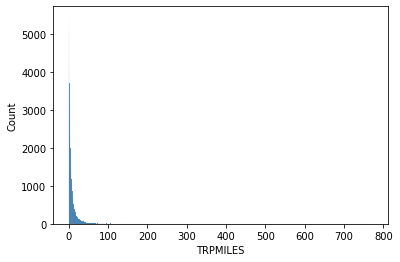

In [10]:
#Remove outlier trip miles
sns.histplot(ny_trip['TRPMILES'])
#ny_trip = ny_trip[ny_trip['TRPMILES']<40]
ny_trip = ny_trip[ny_trip['TRPMILES']<100]

In [11]:
# Summarise to Person trip counts 
ny_trip_count = ny_trip[['HOUSEID','PERSONID','TRAVDAY']].groupby(['HOUSEID','PERSONID']).agg('count').reset_index().rename(columns = {'TRAVDAY':'n_trips'})

In [12]:
ny_trip_count.head()

,HOUSEID,PERSONID,n_trips
0,30000012,1,9
1,30000082,1,5
2,30000082,2,5
3,30000380,1,3
4,30000380,2,8


In [13]:
trips_data = ny_trip[['HOUSEID','PERSONID','WHYTRP90','TRPMILES']]
trips_data['WHYTRP90'].value_counts()

# top why trips are [3,10,4,1,,8,5]

3     20107
10    17647
4     16164
1     14051
8      6467
5      5381
6      2746
11     2595
2      1257
99       22
Name: WHYTRP90, dtype: int64

In [14]:
trips_data =trips_data[trips_data['WHYTRP90'].isin([1,10,4,3,8,5])]

               counts  percentage
(-0.001, 1.0]   24049   30.130173
(2.0, 5.0]      16890   21.160906
(5.0, 11.0]     14795   18.536151
(11.0, 99.0]    14614   18.309383
(1.0, 2.0]       9469   11.863387


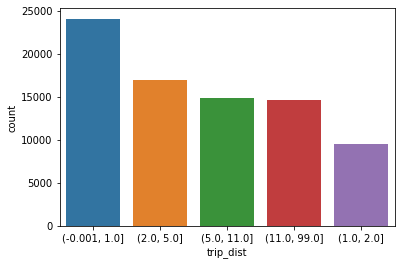

In [15]:
trips_data['round_dist']= trips_data['TRPMILES'].apply(lambda x: math.floor(x))
trips_data['trip_dist'] = pd.qcut(trips_data['round_dist'],5)
cat_col_prop(trips_data,'trip_dist')

In [16]:
trip_summary = trips_data[['HOUSEID','PERSONID','WHYTRP90','trip_dist']].groupby(['HOUSEID','PERSONID','WHYTRP90'])['trip_dist'].apply(pd.Series.mode).reset_index()
trip_summary['max_dist'] = trip_summary['trip_dist'].apply(lambda x: x.right)

In [17]:
trip_summary = trip_summary[trip_summary.groupby(['HOUSEID','PERSONID','WHYTRP90'])['max_dist'].transform(max) == trip_summary['max_dist']]

trip_summary = trip_summary[['HOUSEID','PERSONID','WHYTRP90','trip_dist']]


In [18]:
pivoted = trip_summary.pivot(index = ['HOUSEID','PERSONID'],
                  columns = 'WHYTRP90',
                  values = 'trip_dist')

trip_why_common = pd.DataFrame(pivoted.to_records()).rename(columns = {'1':'dist_to_work',
                                                       '3':'dist_to_shopping',
                                                        '4':'dist_to_family',
                                                       '5':'dist_to_school_or_church',
                                                        '8': 'dist_to_relatives',
                                                        '10':'dist_to_social'})


In [19]:
ny_trip_count = ny_trip_count.merge(trip_why_common, how = 'left',left_on = ['HOUSEID','PERSONID'],right_on = ['HOUSEID','PERSONID'])

## 1.3 People

In [20]:
# filtering people from New York
nyorker = person[person['HOUSEID'].isin(ny['HOUSEID'])]

In [21]:
# selection of columns based on prior background inference of potential features
nyorker = nyorker[['HOUSEID','PERSONID','R_AGE','EDUC','R_RACE','R_SEX','WRK_HOME','WKFTPT','OCCAT','DRIVER','TRAVDAY']]

In [22]:
# merging of Person, Household and Trips to Person
df= nyorker.merge(ny_trip_count, how = 'left', left_on = ['HOUSEID','PERSONID'],right_on = ['HOUSEID','PERSONID'])
df = df.merge(ny, how = 'left', left_on = 'HOUSEID', right_on = 'HOUSEID')

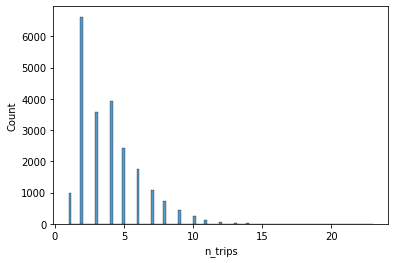

In [23]:
# Replace NA trip counts with 0
sns.histplot(df['n_trips'])
df['n_trips'][df['n_trips'].isna()] = 0
#df = df[df['n_trips']>0]
df = df[df['n_trips']<10]

In [24]:
[c for c in df]

['HOUSEID',
 'PERSONID',
 'R_AGE',
 'EDUC',
 'R_RACE',
 'R_SEX',
 'WRK_HOME',
 'WKFTPT',
 'OCCAT',
 'DRIVER',
 'TRAVDAY',
 'n_trips',
 'dist_to_work',
 'dist_to_shopping',
 'dist_to_family',
 'dist_to_school_or_church',
 'dist_to_relatives',
 'dist_to_social',
 'HH_CBSA',
 'HOMEOWN',
 'HHSIZE',
 'HHVEHCNT',
 'HHFAMINC',
 'NUMADLT',
 'YOUNGCHILD',
 'WRKCOUNT',
 'MSACAT',
 'MSASIZE',
 'URBAN',
 'URBANSIZE',
 'URBRUR',
 'LIF_CYC']

In [25]:
df.shape

(31782, 32)

## 2. EDA & Feature Engineering 

### 2.1. Train, Test, Split

In [26]:
x_col = [c for c in df if c not in ["HOUSEID","PERSONID","n_trips"]]
x_df = df[x_col]
y_df = df['n_trips']

x_train , x_test, y_train, y_test = model_selection.train_test_split(x_df, y_df, test_size = 0.2, random_state = 888)

In [27]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25425 entries, 19406 to 10938
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype            
---  ------                    --------------  -----            
 0   R_AGE                     25425 non-null  int64            
 1   EDUC                      25425 non-null  int64            
 2   R_RACE                    25425 non-null  int64            
 3   R_SEX                     25425 non-null  int64            
 4   WRK_HOME                  25425 non-null  int64            
 5   WKFTPT                    25425 non-null  int64            
 6   OCCAT                     25425 non-null  int64            
 7   DRIVER                    25425 non-null  int64            
 8   TRAVDAY                   25425 non-null  int64            
 9   dist_to_work              5541 non-null   interval[float64]
 10  dist_to_shopping          7272 non-null   interval[float64]
 11  dist_to_family            5551 non-nu

### 2.2. Feature Engineering

#### Age (R_AGE)

65 count of people with no age.  0.00029519289720475033 %.


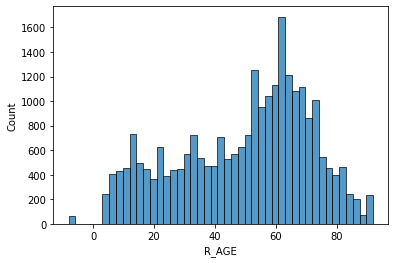

In [28]:
print(str(sum(x_train['R_AGE']<0)), "count of people with no age. ",str(sum(nyorker['R_AGE']<0)/person.shape[0]),"%.")

sns.histplot(x_train['R_AGE'])

# impute missing values (<0) with mean age
mean_age = round(x_train['R_AGE'][x_train['R_AGE']>0].mean())
x_train['R_AGE'][x_train['R_AGE']<0] = mean_age
x_test['R_AGE'][x_test['R_AGE']<0] = mean_age

In [29]:
x_train['AGE_bins']= 'NA'
x_train.loc[x_train['R_AGE'].between(5,15,inclusive = True), 'AGE_bins'] = "5_to_15"
x_train.loc[x_train['R_AGE'].between(16,25,inclusive = True), 'AGE_bins'] = "16_to_25"
x_train.loc[x_train['R_AGE'].between(26,35,inclusive = True), 'AGE_bins'] = "26_to_35"
x_train.loc[x_train['R_AGE'].between(36,45,inclusive = True), 'AGE_bins'] = "36_to_45"
x_train.loc[x_train['R_AGE'].between(46,55,inclusive = True), 'AGE_bins'] = "46_to_55"
x_train.loc[x_train['R_AGE'].between(56,65,inclusive = True), 'AGE_bins'] = "56_to_65"
x_train.loc[x_train['R_AGE'].between(66,75,inclusive = True), 'AGE_bins'] = "66_to_75"
x_train.loc[x_train['R_AGE']>75, 'AGE_bins'] = "more_than_75"

x_test['AGE_bins']= 'NA'
x_test.loc[x_test['R_AGE'].between(5,15,inclusive = True), 'AGE_bins'] = "5_to_15"
x_test.loc[x_test['R_AGE'].between(16,25,inclusive = True), 'AGE_bins'] = "16_to_25"
x_test.loc[x_test['R_AGE'].between(26,35,inclusive = True), 'AGE_bins'] = "26_to_35"
x_test.loc[x_test['R_AGE'].between(36,45,inclusive = True), 'AGE_bins'] = "36_to_45"
x_test.loc[x_test['R_AGE'].between(46,55,inclusive = True), 'AGE_bins'] = "46_to_55"
x_test.loc[x_test['R_AGE'].between(56,65,inclusive = True), 'AGE_bins'] = "56_to_65"
x_test.loc[x_test['R_AGE'].between(66,75,inclusive = True), 'AGE_bins'] = "66_to_75"
x_test.loc[x_test['R_AGE']>75, 'AGE_bins'] = "more_than_75"


              counts  percentage
56_to_65        5534   21.765978
66_to_75        4356   17.132743
46_to_55        3724   14.647001
5_to_15         2491    9.797443
26_to_35        2466    9.699115
36_to_45        2436    9.581121
more_than_75    2322    9.132743
16_to_25        2096    8.243854


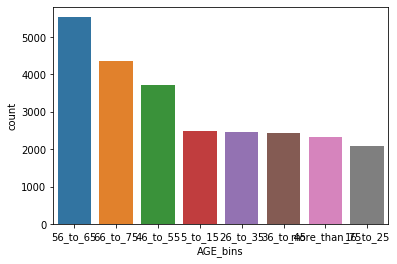

In [30]:
cat_col_prop(x_train,'AGE_bins')

#### Educational Attainment (EDUC)

    counts  percentage
 3    6293   24.751229
 5    5612   22.072763
 2    4965   19.528024
 4    4870   19.154376
-1    2002    7.874140
 1    1668    6.560472
-7      10    0.039331
-8       5    0.019666


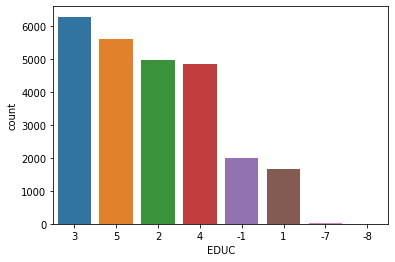

In [31]:
cat_col_prop(x_train,'EDUC')
# approx 8% missing values (<0). To take note of but will addresss in one-hot encoding

#### Race (R_RACE)

     counts  percentage
 1    22734   89.415929
 3      834    3.280236
 2      794    3.122911
 6      530    2.084562
 97     323    1.270403
-7      113    0.444444
 4       69    0.271386
 5       14    0.055064
-8       14    0.055064


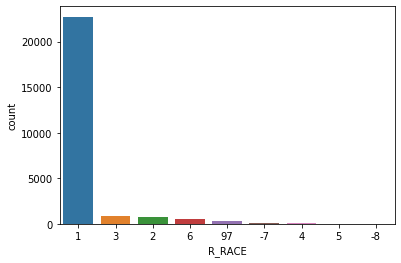

In [32]:
cat_col_prop(x_train,'R_RACE')
# approx 1% missing values (<0). To take note of but will address in one-hot encoding
# Significant proportion of members 'white'

#### Gender (R_SEX)

    counts  percentage
 2   13302   52.318584
 1   12098   47.583088
-7      21    0.082596
-8       4    0.015733


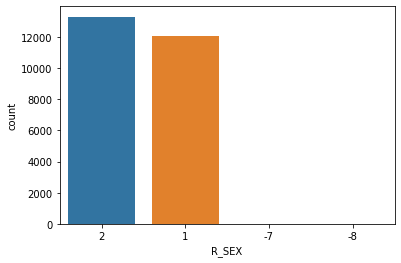

In [33]:
cat_col_prop(x_train, 'R_SEX')
# <1% missing values. To take note but will be addressed in one-hot encoding

#### Work From Home (WRK_HOME)

    counts  percentage
-1   12738   50.100295
 2   10825   42.576205
 1    1371    5.392330
-9     490    1.927237
-7       1    0.003933


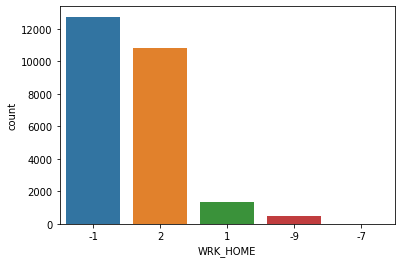

In [34]:
cat_col_prop(x_train,'WRK_HOME')
# Significant proportion -1 (50%) which is the appropriate skip (due to not working) - to address in one-hot

#### Work - Part Time or Full Time (WKFTPT)

    counts  percentage
-1   13228   52.027532
 1    9442   37.136676
 2    2747   10.804326
-7       6    0.023599
-8       2    0.007866


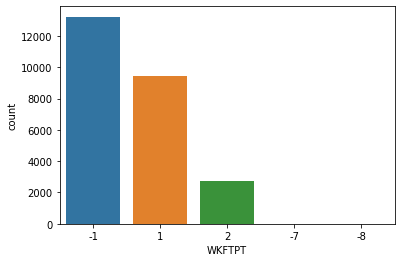

In [35]:
cat_col_prop(x_train,'WKFTPT')
# Significant proportion -1 (52%) which is the appropriate skip (due to not working) - to address in one-hot

#### Job Category (OCCAT)

     counts  percentage
-1    12738   50.100295
 4     6694   26.328417
 1     2585   10.167158
 3     1482    5.828909
 2     1415    5.565388
-9      490    1.927237
 97      15    0.058997
-8        4    0.015733
-7        2    0.007866


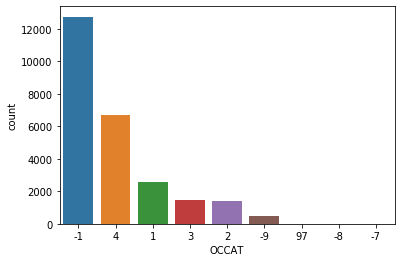

In [36]:
cat_col_prop(x_train,'OCCAT')
# Significant proportion -1 (50%) which is the appropriate skip (due to not working) - to address in one-hot

#### Driver Status (DRIVER)

    counts  percentage
 1   21439   84.322517
-1    2265    8.908555
 2    1721    6.768928


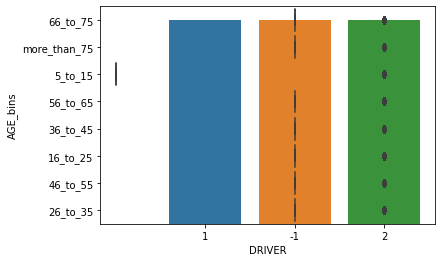

In [37]:
cat_col_prop(x_train,'DRIVER')

#Significant proportion -1 (8.7%) (due to too young) - to address in one-hot encoding
sns.boxplot(data = x_train, x='DRIVER',y='AGE_bins')

#### Travel Day (TRAVDAY)

   counts  percentage
1    3763   14.800393
2    3720   14.631268
7    3716   14.615536
5    3636   14.300885
6    3574   14.057030
3    3547   13.950836
4    3469   13.644051


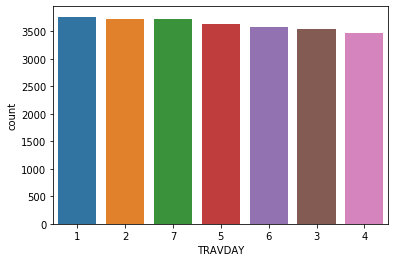

In [38]:
cat_col_prop(x_train,'TRAVDAY')

#### Core Based Statiscal Area FIPS code (HH_CBSA)

       counts  percentage
XXXXX   15006   59.020649
35620    7719   30.359882
40380    1467    5.769912
15380    1233    4.849558


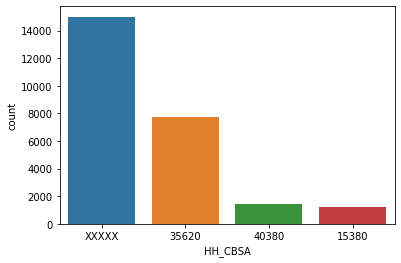

In [39]:
#Core Based Statistical Area (CBSA) FIPS code for the respondent's home address

cat_col_prop(x_train,'HH_CBSA')

# significant number of households under the 'XXXXX=Suppressed, in an MSA of less than 1 million ' category

####  Home Ownership (HOMEOWN)

     counts  percentage
 1    21452   84.373648
 2     3776   14.851524
 97     196    0.770895
-7        1    0.003933


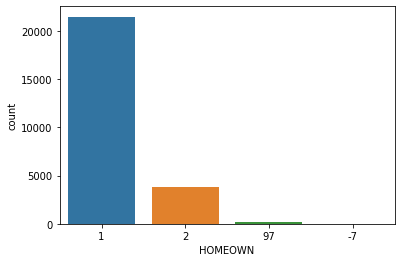

In [40]:
cat_col_prop(x_train,'HOMEOWN')
#Small count with missing value 2. to address in one-hot encoding

#### Household Vehicle Count (HHVEHCNT)

    counts  percentage
2    11356   44.664700
1     6591   25.923304
3     4623   18.182891
4     1829    7.193707
5      662    2.603736
6      245    0.963618
7       80    0.314651
8       22    0.086529
11       9    0.035398
9        6    0.023599
12       2    0.007866
________
new HHVEHCNT
    counts  percentage
2    11356   44.664700
1     6591   25.923304
3     4623   18.182891
>3    2855   11.229105


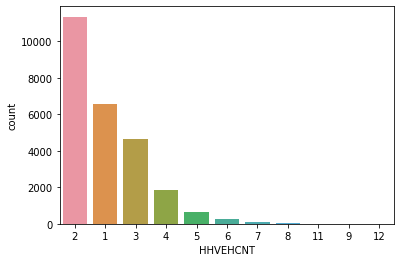

In [41]:
#count of household vehicles

cat_col_prop(x_train,'HHVEHCNT')

# as group size significantly smaller from 4 and above to bin to a single group

x_train['HHVEHCNT'][x_train['HHVEHCNT']>3] = ">3"
x_test['HHVEHCNT'][x_test['HHVEHCNT']>3] = ">3"

print("________")
print("new HHVEHCNT")
print(pd.concat([x_train['HHVEHCNT'].value_counts(),
          x_train['HHVEHCNT'].value_counts(normalize = True).mul(100)],axis = 1, keys = ('counts','percentage'))
    )

#### Family Income (HHFAMINC)

     counts  percentage
 6     4580   18.013766
 7     3829   15.059980
 8     3144   12.365782
 5     2664   10.477876
 4     1974    7.764012
 11    1874    7.370698
 9     1860    7.315634
 10    1780    7.000983
 3     1590    6.253687
-7      742    2.918387
 2      732    2.879056
 1      557    2.190757
-8       97    0.381514
-9        2    0.007866


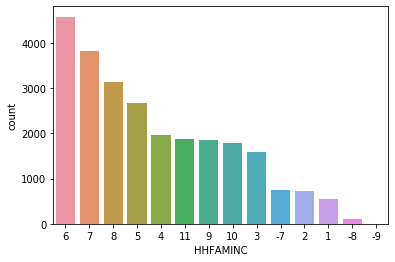

In [42]:
cat_col_prop(x_train,'HHFAMINC')
# approx 3% missing (<0) to address in one-hot encoding

#### Adult Ratio  (NUMADLT)

    counts  percentage
2    16118   63.394297
1     4266   16.778761
3     3501   13.769912
4     1192    4.688299
5      286    1.124877
6       38    0.149459
7       11    0.043265
10       7    0.027532
8        6    0.023599


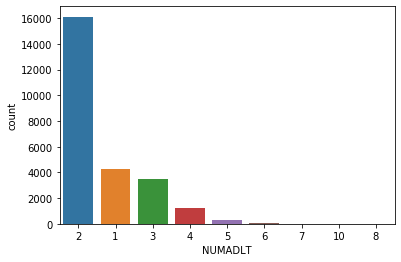

In [43]:
cat_col_prop(x_train, 'NUMADLT')
#no missing values

Before
          counts  percentage
1.000000   17591   69.187807
0.500000    2802   11.020649
0.666667    1929    7.587021
0.400000     895    3.520157
0.750000     656    2.580138
0.333333     509    2.001967
0.600000     378    1.486726
0.800000     213    0.837758
0.250000      93    0.365782
0.285714      78    0.306785
0.714286      53    0.208456
0.833333      42    0.165192
0.428571      40    0.157325
0.571429      34    0.133727
0.375000      20    0.078663
0.222222      17    0.066863
0.625000      17    0.066863
0.200000      15    0.058997
0.444444      11    0.043265
0.166667      10    0.039331
0.700000       7    0.027532
0.142857       6    0.023599
0.857143       5    0.019666
0.363636       4    0.015733

After
               counts  percentage
1               17591   69.187807
more_than_0.5    6136   24.133727
less_than_0.5    1698    6.678466


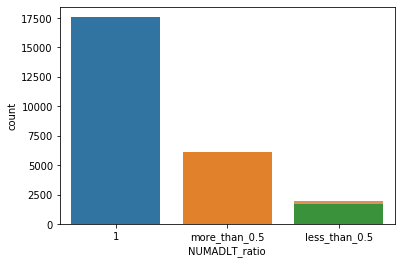

In [44]:
#Convert against proportion of Household size
x_train['NUMADLT'] = x_train['NUMADLT']/x_train['HHSIZE']
x_test['NUMADLT'] = x_test['NUMADLT']/x_test['HHSIZE']
print('Before')
cat_col_prop(x_train,'NUMADLT')
#significant number of varying factors
#to bin into groups
x_train['NUMADLT_ratio'] = 'NA'
x_train.loc[x_train['NUMADLT']==0, 'NUMADLT_ratio'] = '0'
x_train.loc[x_train['NUMADLT'].between(0,0.5,inclusive = False),'NUMADLT_ratio'] = 'less_than_0.5'
x_train.loc[x_train['NUMADLT'].between(0.5,1, inclusive = True),'NUMADLT_ratio'] = 'more_than_0.5'
x_train.loc[x_train['NUMADLT']==1,'NUMADLT_ratio'] ='1'
print('')
print('After')
cat_col_prop(x_train,'NUMADLT_ratio')


x_test['NUMADLT_ratio'] = 'NA'
x_test.loc[x_test['NUMADLT']==0, 'NUMADLT_ratio'] = '0'
x_test.loc[x_test['NUMADLT'].between(0,0.5,inclusive = False),'NUMADLT_ratio'] = 'less_than_0.5'
x_test.loc[x_test['NUMADLT'].between(0.5,1, inclusive = True),'NUMADLT_ratio'] = 'more_than_0.5'
x_test.loc[x_test['NUMADLT']==1,'NUMADLT_ratio'] ='1'

#### Young Child Ratio (YOUNGCHILD)

   counts  percentage
0   23182   91.177974
1    1671    6.572271
2     518    2.037365
3      49    0.192724
5       4    0.015733
4       1    0.003933


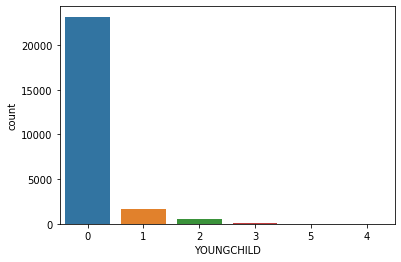

In [45]:
cat_col_prop(x_train,'YOUNGCHILD')

               counts  percentage
0               23182   91.177974
less_than_0.5    1938    7.622419
more_than_0.5     305    1.199607


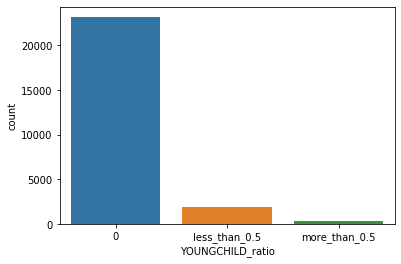

In [46]:
#Convert against proportion of Household size

x_train['YOUNGCHILD'] = x_train['YOUNGCHILD']/x_train['HHSIZE']
x_test['YOUNGCHILD'] = x_test['YOUNGCHILD']/x_test['HHSIZE']

#Bin to groups
x_train['YOUNGCHILD_ratio'] = 'NA'
x_train.loc[x_train['YOUNGCHILD']==0,'YOUNGCHILD_ratio']= '0'
x_train.loc[x_train['YOUNGCHILD'].between(0,0.5,inclusive = False),'YOUNGCHILD_ratio'] = 'less_than_0.5'
x_train.loc[x_train['YOUNGCHILD'].between(0.5,1, inclusive = True),'YOUNGCHILD_ratio'] = 'more_than_0.5'
x_train.loc[x_train['YOUNGCHILD']==1,'YOUNGCHILD_ratio'] ='1'
 

cat_col_prop(x_train,'YOUNGCHILD_ratio')    

x_test['YOUNGCHILD_ratio'] = 'NA'
x_test.loc[x_test['YOUNGCHILD']==0,'YOUNGCHILD_ratio']= '0'
x_test.loc[x_test['YOUNGCHILD'].between(0,0.5,inclusive = False),'YOUNGCHILD_ratio'] = 'less_than_0.5'
x_test.loc[x_test['YOUNGCHILD'].between(0.5,1, inclusive = True),'YOUNGCHILD_ratio'] = 'more_than_0.5'
x_test.loc[x_test['YOUNGCHILD']==1,'YOUNGCHILD_ratio'] ='1'
 


#### Worker Count Proportion (WRKCOUNT)

   counts  percentage
2    8775   34.513274
1    7693   30.257620
0    6707   26.379548
3    1671    6.572271
4     513    2.017699
5      55    0.216323
7       6    0.023599
6       5    0.019666


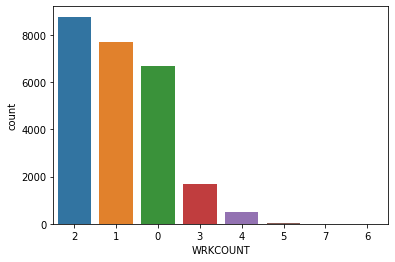

In [47]:
cat_col_prop(x_train,'WRKCOUNT')

               counts  percentage
more_than_0.5    8284   32.582104
0                6707   26.379548
1                6416   25.235005
less_than_0.5    4018   15.803343


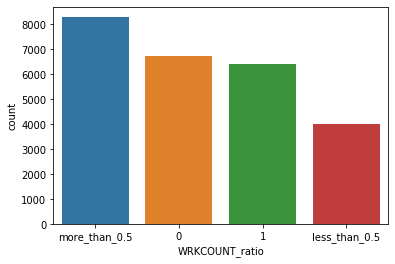

In [48]:
#Convert against proportion of Household size

x_train['WRKCOUNT'] = x_train['WRKCOUNT']/x_train['HHSIZE']
x_test['WRKCOUNT'] = x_test['WRKCOUNT']/x_test['HHSIZE']

#Bin to groups
x_train['WRKCOUNT_ratio'] = 'NA'
x_train.loc[x_train['WRKCOUNT']==0,'WRKCOUNT_ratio']= '0'
x_train.loc[x_train['WRKCOUNT'].between(0,0.5,inclusive = False),'WRKCOUNT_ratio'] = 'less_than_0.5'
x_train.loc[x_train['WRKCOUNT'].between(0.5,1, inclusive = True),'WRKCOUNT_ratio'] = 'more_than_0.5'
x_train.loc[x_train['WRKCOUNT']==1,'WRKCOUNT_ratio'] ='1'

cat_col_prop(x_train,'WRKCOUNT_ratio')

x_test['WRKCOUNT_ratio'] = 'NA'
x_test.loc[x_test['WRKCOUNT']==0,'WRKCOUNT_ratio']= '0'
x_test.loc[x_test['WRKCOUNT'].between(0,0.5,inclusive = False),'WRKCOUNT_ratio'] = 'less_than_0.5'
x_test.loc[x_test['WRKCOUNT'].between(0.5,1, inclusive = True),'WRKCOUNT_ratio'] = 'more_than_0.5'
x_test.loc[x_test['WRKCOUNT']==1,'WRKCOUNT_ratio'] ='1'

 

#### Household Size (HHSIZE)

Before
    counts  percentage
2    10847   42.662734
3     4371   17.191740
4     3952   15.543756
1     3675   14.454277
5     1663    6.540806
6      537    2.112094
7      220    0.865290
8       91    0.357915
9       39    0.153392
10      26    0.102262
11       4    0.015733

After
         counts  percentage
2         10847   42.662734
above_3    6532   25.691249
3          4371   17.191740
1          3675   14.454277


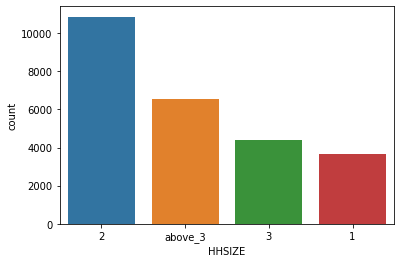

In [49]:
#count of household members
print("Before")
cat_col_prop(x_train,'HHSIZE')

# to bin tail HHSIZE

x_train['HHSIZE'][x_train['HHSIZE']>3] = "above_3"

print("")
print("After")

cat_col_prop(x_train,'HHSIZE')

x_test['HHSIZE'][x_test['HHSIZE']>3] = " above_3"

#### Metropolitan Statistical Area (MSACAT)


   counts  percentage
3   10912   42.918387
1    7719   30.359882
4    4094   16.102262
2    2700   10.619469


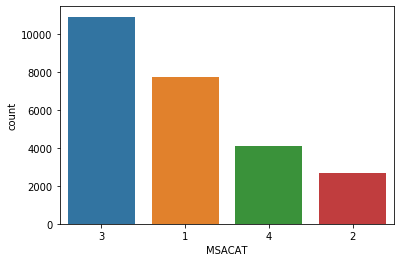

In [50]:
cat_col_prop(x_train,'MSACAT')
             
#no missing values and relatively proportional distribution

#### Population size of MSA (MSASIZE)

   counts  percentage
5    7719   30.359882
1    6322   24.865290
6    4094   16.102262
3    3471   13.651917
4    2700   10.619469
2    1119    4.401180


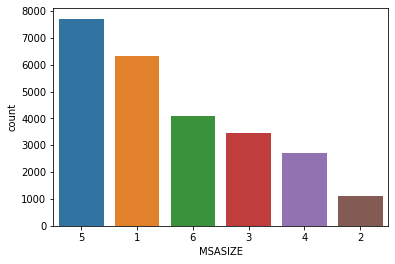

In [51]:
cat_col_prop(x_train,'MSASIZE')
             
#no missing values and relatively proportional distribution

#### House in Urban or Rural Area (URBAN)

Before
   counts  percentage
1   14285   56.184857
4    8638   33.974435
2    2497    9.821042
3       5    0.019666

After
       counts  percentage
urban   16782     66.0059
rural    8643     33.9941


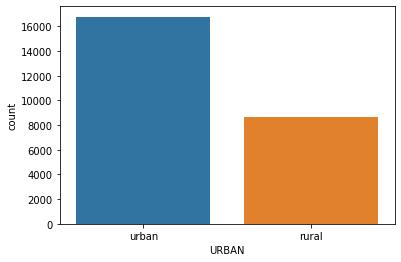

In [52]:
print('Before')
cat_col_prop(x_train,'URBAN')

# combine 1 and 2 (in an urban area and in an urban cluster ) & combine 3 and 4 (surround by urban and not in urban)

x_train['URBAN'][x_train['URBAN'].isin([1,2])] = 'urban'
x_train['URBAN'][x_train['URBAN'].isin([3,4])] = 'rural'

print("")
print('After')

cat_col_prop(x_train, 'URBAN')

x_test['URBAN'][x_test['URBAN'].isin([1,2])] = 'urban'
x_test['URBAN'][x_test['URBAN'].isin([3,4])] = 'rural'

#### URBANSIZE

   counts  percentage
6   11140   43.815143
5    4990   19.626352
1    3821   15.028515
3    2868   11.280236
2    2606   10.249754


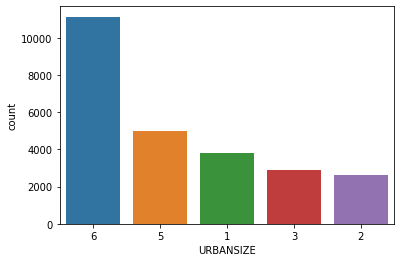

In [53]:
#06 = not in an urbanised area 
#05 - 1 million with heavy rail 

#Relatively proportional classes
cat_col_prop(x_train,'URBANSIZE')

#### URBRUR

   counts  percentage
1   16782     66.0059
2    8643     33.9941


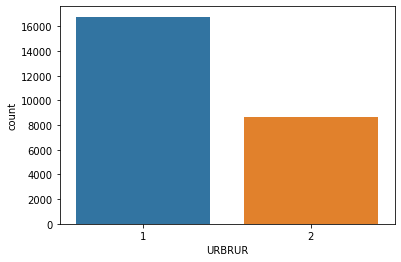

In [54]:
cat_col_prop(x_train,'URBRUR')
# missing values nor disproportion

#### LIF_CYC 

    counts  percentage
10    7019   27.606686
2     5796   22.796460
6     3870   15.221239
4     2543   10.001967
1     1937    7.618486
9     1738    6.835792
8     1693    6.658800
5      460    1.809243
7      211    0.829892
3      158    0.621436


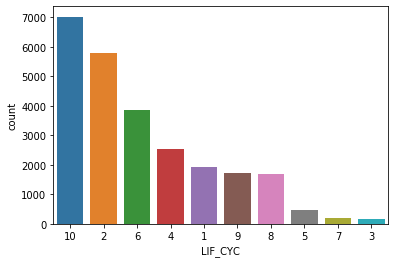

In [55]:
cat_col_prop(x_train,"LIF_CYC")

# No major disproportion

## 3. One-Hot- Encoding

In [56]:
x_train.dtypes

R_AGE                                   int64
EDUC                                    int64
R_RACE                                  int64
R_SEX                                   int64
WRK_HOME                                int64
WKFTPT                                  int64
OCCAT                                   int64
DRIVER                                  int64
TRAVDAY                                 int64
dist_to_work                interval[float64]
dist_to_shopping            interval[float64]
dist_to_family              interval[float64]
dist_to_school_or_church    interval[float64]
dist_to_relatives           interval[float64]
dist_to_social              interval[float64]
HH_CBSA                                object
HOMEOWN                                 int64
HHSIZE                                 object
HHVEHCNT                               object
HHFAMINC                                int64
NUMADLT                               float64
YOUNGCHILD                        

In [57]:
to_obj = ['EDUC','R_RACE','AGE_bins','HHFAMINC','HOMEOWN','R_SEX','TRAVDAY','WRK_HOME','WKFTPT','OCCAT','DRIVER','MSACAT','MSASIZE','URBAN','URBANSIZE','URBRUR','LIF_CYC','dist_to_work','dist_to_shopping','dist_to_family','dist_to_school_or_church','dist_to_relatives','dist_to_social']

x_train[to_obj] = x_train[to_obj].astype(str)
x_test[to_obj]= x_test[to_obj].astype(str)

x_train.drop(['R_AGE'], axis = 1, inplace =True)
x_test.drop(['R_AGE'],axis = 1, inplace = True)

In [58]:
one_hot_col = [c for c in x_train if x_train[c].dtypes == 'O' ]
x_train = pd.concat([x_train,pd.get_dummies(x_train[one_hot_col],prefix = one_hot_col)],axis = 1)
x_train.drop(one_hot_col, axis = 1, inplace = True)

x_test = pd.concat([x_test,pd.get_dummies(x_test[one_hot_col],prefix = one_hot_col)],axis = 1)
x_test.drop(one_hot_col, axis = 1, inplace = True)

In [59]:

#y_train = y_train.astype('int64')
#y_test = y_test.astype('int64')

In [60]:
#drop all negative value columns  

na_cols_train =[c for c in x_train if ('NA' in c) or ('-' in c) or ('nan' in c)]

x_train.drop(na_cols_train, axis = 1, inplace = True)


na_cols_test =[c for c in x_test if ('NA' in c) or ('-' in c) or ('nan' in c)]
x_test.drop(na_cols_test, axis = 1 , inplace = True)

In [61]:
x_train.shape

(25425, 132)

In [62]:
x_test.shape

(6357, 132)

In [63]:
x_train

,NUMADLT,YOUNGCHILD,WRKCOUNT,EDUC_1,EDUC_2,EDUC_3,EDUC_4,EDUC_5,R_RACE_1,R_RACE_2,...,NUMADLT_ratio_1,NUMADLT_ratio_less_than_0.5,NUMADLT_ratio_more_than_0.5,YOUNGCHILD_ratio_0,YOUNGCHILD_ratio_less_than_0.5,YOUNGCHILD_ratio_more_than_0.5,WRKCOUNT_ratio_0,WRKCOUNT_ratio_1,WRKCOUNT_ratio_less_than_0.5,WRKCOUNT_ratio_more_than_0.5
19406,1.0,0.0,1.00,0,0,0,0,1,1,0,...,1,0,0,1,0,0,0,1,0,0
19181,1.0,0.0,1.00,0,0,1,0,0,1,0,...,1,0,0,1,0,0,0,1,0,0
15046,0.5,0.0,0.25,0,0,0,0,0,1,0,...,0,0,1,1,0,0,0,0,1,0
229,1.0,0.0,0.00,0,0,0,0,1,1,0,...,1,0,0,1,0,0,1,0,0,0
11509,1.0,0.0,0.00,0,0,1,0,0,1,0,...,1,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5378,1.0,0.0,1.00,0,1,0,0,0,1,0,...,1,0,0,1,0,0,0,1,0,0
26272,1.0,0.0,0.50,0,0,0,1,0,1,0,...,1,0,0,1,0,0,0,0,0,1
15091,1.0,0.0,1.00,0,0,0,0,1,1,0,...,1,0,0,1,0,0,0,1,0,0
1984,1.0,0.0,1.00,0,0,0,0,1,0,0,...,1,0,0,1,0,0,0,1,0,0


In [64]:
dist_dict = {'dist_to_work_(1.0, 2.0]':'dist_to_work_between_1_and_2',
            'dist_to_work_(11.0, 99.0]':'dist_to_work_more_than_11',
            'dist_to_work_(2.0, 5.0]':'dist_to_work_between_2_and_5',
            'dist_to_work_(5.0, 11.0]':'dist_to_work_between_5_and_11',
             'dist_to_shopping_(1.0, 2.0]':'dist_to_shopping_between_1_and_2',
             'dist_to_shopping_(11.0, 99.0]':'dist_to_shopping_more_than_11',
             'dist_to_shopping_(2.0, 5.0]':'dist_to_shopping_between_2_and_5',
             'dist_to_shopping_(5.0, 11.0]':'dist_to_shopping_between_5_and_11',
             'dist_to_family_(1.0, 2.0]':'dist_to_family_between_1_and_2',
             'dist_to_family_(11.0, 99.0]':'dist_to_family_greater_than_11',
             'dist_to_family_(2.0, 5.0]':'dist_to_family_between_2_and_5',
             'dist_to_family_(5.0, 11.0]':'dist_to_family_between_5_and_11',
             'dist_to_school_or_church_(1.0, 2.0]':'dist_to_school_or_church_between_1_and_2',
             'dist_to_school_or_church_(11.0, 99.0]':'dist_to_school_or_church_greater_than_11',
             'dist_to_school_or_church_(2.0, 5.0]':'dist_to_school_or_church_between_2_and_5',
             'dist_to_school_or_church_(5.0, 11.0]':'dist_to_school_or_church_between_5_and_11',
             'dist_to_relatives_(1.0, 2.0]':'dist_to_relatvies_between_1_and_2',
             'dist_to_relatives_(11.0, 99.0]':'dist_to_relatvies_greater_than_11',
             'dist_to_relatives_(2.0, 5.0]':'dist_to_relatvies_between_2_and_5',
             'dist_to_relatives_(5.0, 11.0]':'dist_to_relatvies_between_5_and_11',
             'dist_to_social_(1.0, 2.0]':'dist_to_social_between_1_and_2',
             'dist_to_social_(11.0, 99.0]':'dist_to_social_greater_than_11',
             'dist_to_social_(2.0, 5.0]':'dist_to_social_between_2_and_5',
             'dist_to_social_(5.0, 11.0]':'dist_to_social_between_5_and_11'}

dist_cols = [c for c in x_train if 'dist' in c]

x_train.rename(columns=dist_dict,inplace = True)
x_test.rename(columns = dist_dict, inplace = True)

## Models

### Linear Regression

In [65]:
#Checking for multicollinearity through variance Inflation Factor 
#VIF=1, Very Less Multicollinearity
#VIF<5, Moderate Multicollinearity
#VIF>5, Extreme Multicollinearity (This is what we have to avoid)

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import linear_model, model_selection, metrics


In [66]:
LRmodel = linear_model.LinearRegression()  #create the linear regression 
LRmodel.fit(x_train,y_train) #train the model using the training set 
LR_pred = LRmodel.predict(x_test) #use this model to predict the test data set 

In [67]:
print('R^2 score:\t\t\t\t',LRmodel.score(x_test, y_test)) #compute R^2 score 
print('Explained Variance: \t\t\t', metrics.explained_variance_score(y_test, LR_pred)) #compute explained variance score
print('Mean Absolute Error: \t\t\t', metrics.mean_absolute_error(y_test, LR_pred)) #compute MAE results
print('Mean Squared Error:\t\t\t', metrics.mean_squared_error(y_test, LR_pred)) #compute MSE results
print('Root Mean Squared Error:\t\t', metrics.mean_squared_error(y_test, LR_pred, squared = False)) #compute RSME results
print('Intercept:\t', LRmodel.intercept_) #find intercept value 
print('Coef:\t', np.sum(LRmodel.coef_!=0))#find no of features used in regression model 

R^2 score:				 0.5658430062062544
Explained Variance: 			 0.5658481372632194
Mean Absolute Error: 			 1.1638533463357323
Mean Squared Error:			 2.393743235190672
Root Mean Squared Error:		 1.5471726584937675
Intercept:	 3332873449928.104
Coef:	 132


In [68]:
#x_train_sm= sm.add_constant(x_train)
#ls=sm.OLS(y_train,x_train_sm).fit()
#print(ls.summary())

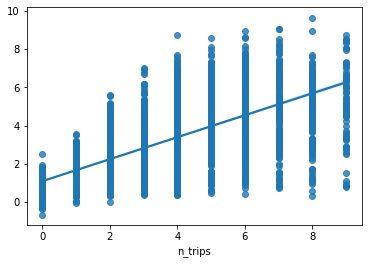

In [69]:
sns.regplot(y_test,LR_pred) #plotting predictions 

In [70]:
#calculate VIF scores to detect multicolinearity 

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = x_train.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(x_train.values, i)
                          for i in range(len(x_train.columns))]
  
print(vif_data)

                            feature        VIF
0                           NUMADLT  29.510298
1                        YOUNGCHILD  20.291842
2                          WRKCOUNT  60.887213
3                            EDUC_1   6.456246
4                            EDUC_2  21.060117
..                              ...        ...
127  YOUNGCHILD_ratio_more_than_0.5        inf
128                WRKCOUNT_ratio_0        inf
129                WRKCOUNT_ratio_1        inf
130    WRKCOUNT_ratio_less_than_0.5        inf
131    WRKCOUNT_ratio_more_than_0.5        inf

[132 rows x 2 columns]


In [71]:
vif_data.sort_values(by = 'VIF', ascending = False)

,feature,VIF
66,HHSIZE_1,inf
89,MSASIZE_1,inf
101,URBANSIZE_6,inf
100,URBANSIZE_5,inf
99,URBANSIZE_3,inf
...,...,...
54,dist_to_relatvies_between_5_and_11,1.018572
48,dist_to_school_or_church_greater_than_11,1.018423
50,dist_to_school_or_church_between_5_and_11,1.018231
53,dist_to_relatvies_between_2_and_5,1.016029


In [72]:
# counting number of infinity features 

vif_data_inf = np.isinf(vif_data['VIF']).values.sum()
print("It contains " + str(vif_data_inf) + " infinite values")

It contains 66 infinite values


#### Linear Regression - Regularisation

**Lasso Regularisation**

In [73]:
alpha = [0.0001, 0.001, 0.005, 0.01]

for i in range(4):
    #build lasso regressor model here
    lasso = linear_model.Lasso(alpha=alpha[i])
    lasso.fit(x_train, y_train) #fit a lasso regression on the training data
    y_predlasso = lasso.predict(x_test) #use this model to predict the test data
    lasso_mse = metrics.mean_squared_error(y_test, y_predlasso) #calculate the test MSE
    lasso_rmse = metrics.mean_squared_error(y_test, y_predlasso,squared = False) #calculate the test RMSE
    msemanual = np.mean((y_predlasso-y_test)**2) #calculate mse manually to cross validate
    lasso_cplxy = (np.sum(abs(lasso.coef_))) #calculate l1norm / model complexity
    
    print('-' * 32)
    print('lasso with alpha', alpha[i])
    print('-' * 32)
    print('\nTrain score:', round(lasso.score(x_train, y_train), 3)) #compute train R^2 score
    print('Test score:', round(lasso.score(x_test, y_test), 3)) #compute test R^2 score
    print(list(map(lambda x: round(x, 3), lasso.coef_))) #list out the coef values 
    print('-' * 32)
    print('MSE on test set:', lasso_mse) #compute MSE results
    print('Manual MSE on test set:',msemanual) #compute MSE results
    print('RMSE on test set:', lasso_rmse) #compute RMSE results
    print('model complexity:', lasso_cplxy) #compute L1 NOMR score
    print('regularized cost:', lasso_mse + alpha[i] * lasso_cplxy) #compute regularised cost function scores
    print('\n')
   

--------------------------------
lasso with alpha 0.0001
--------------------------------

Train score: 0.568
Test score: 0.566
[-0.732, 0.0, 0.145, -0.227, -0.184, -0.118, -0.056, -0.052, -0.056, -0.123, -0.26, 0.084, -0.048, -0.131, -0.24, 0.002, 0.116, -0.0, 0.009, 0.0, 0.168, 0.108, 0.047, -0.153, 0.036, 0.848, 0.64, 0.152, -0.175, -0.051, 0.02, 0.082, -0.0, 0.071, -0.018, 1.626, 1.254, 1.471, 1.375, 1.786, 1.834, 1.862, 1.939, 2.252, 1.987, 2.172, 2.118, 1.569, 1.448, 1.527, 1.58, 1.656, 1.402, 1.751, 1.665, 1.942, 1.646, 1.944, 1.849, 0.111, -0.106, -0.038, 0.009, 0.003, -0.027, 0.0, 0.076, 0.037, -0.011, -0.01, 0.042, 0.045, -0.019, -0.027, -0.114, 0.029, 0.088, 0.023, 0.018, 0.1, 0.095, 0.063, 0.082, 0.037, 0.065, -0.008, 0.0, -0.0, 0.04, -0.0, 0.074, -0.026, 0.0, -0.0, 0.001, -0.4, 0.0, 0.021, -0.105, -0.048, -0.0, 0.215, 0.203, -0.0, -0.0, -0.104, -0.126, 0.0, 0.028, 0.005, -0.099, 0.003, -0.073, 0.081, -0.283, -0.18, -0.119, -0.073, 0.014, 0.0, 0.071, 0.096, 0.112, -0.132, -

**Ridge Regularisation**

In [74]:
ridgealpha = [0.001, 0.01, 0.1, 1]

for i in range(4):
    #build ridge regressor here
    ridge = linear_model.Ridge(alpha=ridgealpha[i])
    ridge.fit(x_train, y_train) #fit a ridge regression on the training data
    y_pred_ridge = ridge.predict(x_test) #use this model to predict the test data
    ridge_mse = metrics.mean_squared_error(y_test, y_pred_ridge) #calculate the test mse
    ridge_rmse = metrics.mean_squared_error(y_test, y_pred_ridge,squared = False) #calculate the test rmse
    ridge_cplxy = (np.linalg.norm(ridge.coef_)) #calculate l2norm / model complexity
    
    print('-' * 32)
    print('ridge with alpha', ridgealpha[i])
    print('-' * 32)
    print('\nTrain score:', round(ridge.score(x_train, y_train), 3))
    print('Test score:', round(ridge.score(x_test, y_test), 3))
    print(list(map(lambda x: round(x, 3), ridge.coef_)))
    print('-' * 32)
    print('MSE on test set:', ridge_mse)
    print('RMSE on test set:', ridge_rmse)
    print('model complexity:', ridge_cplxy)
    print('regularized cost:', ridge_mse + alpha[i] * ridge_cplxy)
    print('\n')

--------------------------------
ridge with alpha 0.001
--------------------------------

Train score: 0.568
Test score: 0.566
[-0.857, 0.345, 0.261, -0.297, -0.263, -0.198, -0.137, -0.133, -0.176, -0.246, -0.385, -0.001, -0.353, -0.256, -0.363, 0.251, 0.365, -1.343, -1.332, 0.365, 0.533, 1.086, 1.024, 0.821, 1.014, 2.023, 0.744, 0.252, -0.166, -0.041, 0.031, 0.092, 0.011, 0.082, -0.01, 1.631, 1.256, 1.474, 1.377, 1.788, 1.837, 1.864, 1.94, 2.254, 1.989, 2.173, 2.119, 1.575, 1.455, 1.531, 1.588, 1.67, 1.403, 1.755, 1.669, 1.944, 1.648, 1.945, 1.85, 0.085, -0.037, -0.069, 0.021, 0.135, 0.105, 0.135, 0.08, 0.01, -0.048, -0.041, 0.032, 0.035, -0.03, -0.037, -0.087, 0.06, 0.118, 0.056, 0.049, 0.13, 0.124, 0.094, 0.112, 0.068, 0.096, -0.037, 0.016, 0.005, 0.016, -0.014, 0.061, -0.041, 0.016, -0.037, 0.016, -0.152, 0.152, 0.005, -0.124, -0.065, -0.016, 0.201, 0.152, -0.152, -0.001, -0.073, -0.093, 0.031, 0.072, 0.039, -0.064, 0.045, -0.037, 0.081, -0.231, -0.128, -0.065, -0.017, 0.071, 0.086

### Principal Component Regression

In [75]:
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn import model_selection


In [76]:
pca = PCA()
x_reduced = pca.fit_transform(scale(x_train))


In [77]:
pd.DataFrame(pca.components_.T).loc[:4,:5]

,0,1,2,3,4,5
0,-0.270902,-0.194997,-0.002249,-0.021970,0.000938,0.034461
1,0.173251,0.134481,-0.047238,0.101146,-0.023086,0.285606
2,0.008301,-0.097557,-0.349333,0.010191,-0.015625,-0.047923
3,0.061964,0.059343,0.069994,-0.026719,0.001765,-0.128893
4,-0.070860,0.013958,0.054563,0.002249,0.019730,0.034307


In [78]:
# 10-fold CV, with shuffle
#n = len(x_reduced)
#kf_10 = model_selection.KFold( n_splits=10, shuffle=True, random_state=1)


#pcamse = []

# Calculate MSE with only the intercept (no principal components in regression)
#pcascore = -1*model_selection.cross_val_score(regr, np.ones((n,1)), y.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()    
#mse.append(score)

# Calculate MSE using CV for the 19 principle components, adding one component at the time.
#for i in np.arange(1, 20):
 #   score = -1*model_selection.cross_val_score(regr, X_reduced[:,:i], y.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
  #  mse.append(score)
    
# Plot results    
#plt.plot(mse, '-v')
#plt.xlabel('Number of principal components in regression')
#plt.ylabel('MSE')
#plt.title('Salary')
#plt.xlim(xmin=-1);

### Random Forest

In [158]:
def evaluate_model(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions-test_labels)
    mse = metrics.mean_squared_error(test_labels,predictions)
    rmse = np.sqrt(mse)
    
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    rsquare = model.score(test_features,test_labels)
    importance = model.feature_importances_

    
    print('Model Preformance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%,'.format(accuracy))
    print('rmse',rmse)
    print('mse',mse)
    print('R square:', rsquare)
    
    print("__________")
    print("Top 5 Features")
    feature_dict = {}
    for i,v in enumerate(importance):
        #print('Feature %0d, Score: %.5f' % (i,v))
        feature_dict[i]=v
    feature_names = test_features.columns
    sorted_features = sorted(feature_dict.items(), key=lambda x: x[1], reverse=True)
    
    for i in sorted_features[:5]:
        print(feature_names[i[0]],i[1])
        
    plt.bar([x for x in range(len(importance))],importance)
    plt.show()
    
    
    
    return accuracy

In [163]:
# Random Forest with RandomSearch
from sklearn import tree, ensemble, model_selection, metrics
from sklearn.model_selection import RandomizedSearchCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics
import time
start_time = time.time()


rf= ensemble.RandomForestRegressor()

n_estimators = [int(i) for i in np.linspace(start = 10, stop = 1000, num=10)]
max_features = [2,5,10,25,50]
max_depth =[int(i) for i in np.linspace(10,100,num = 10)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1,2,4]

random_grid = {'n_estimators':n_estimators,
              'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split':min_samples_split,
               'min_samples_leaf':min_samples_leaf
               }

rf_random = RandomizedSearchCV(estimator = rf, n_jobs = 3, param_distributions = random_grid, verbose=10, cv = model_selection.KFold(n_splits = 5, shuffle = True, random_state = 888))

rf_random.fit(x_train, y_train)

print("run time:", str(time.time()-start_time), "start time:", str(start_time), "end time",str(time.time()))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
run time: 808.5375440120697 start time: 1627438508.1049712 end time 1627439316.6425152


Model Preformance
Average Error: 1.1247 degrees.
Accuracy = -inf%,
rmse 1.5214412898216982
mse 2.3147835983743126
R square: 0.5801640403285736
__________
Top 5 Features
dist_to_family_between_2_and_5 0.061272433508930066
dist_to_family_between_5_and_11 0.057926287877690275
dist_to_shopping_between_2_and_5 0.054248887454825846
dist_to_social_between_2_and_5 0.05412923940979489
dist_to_shopping_between_5_and_11 0.04441709997084931


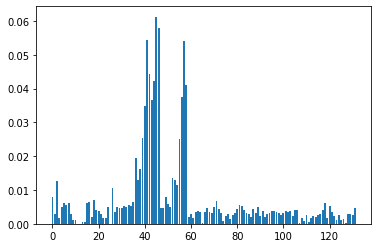

{'n_estimators': 890, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 25, 'max_depth': 40}


In [164]:
best_rf = rf_random.best_estimator_
rf_accuracy = evaluate_model(best_rf, x_test, y_test)
print(rf_random.best_params_)

In [81]:
x_test.shape

(6357, 132)

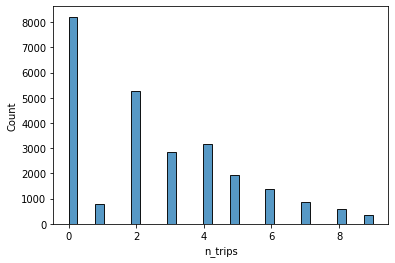

In [82]:
sns.histplot(data = y_train)

In [83]:
[c for c in x_train]

['NUMADLT',
 'YOUNGCHILD',
 'WRKCOUNT',
 'EDUC_1',
 'EDUC_2',
 'EDUC_3',
 'EDUC_4',
 'EDUC_5',
 'R_RACE_1',
 'R_RACE_2',
 'R_RACE_3',
 'R_RACE_4',
 'R_RACE_5',
 'R_RACE_6',
 'R_RACE_97',
 'R_SEX_1',
 'R_SEX_2',
 'WRK_HOME_1',
 'WRK_HOME_2',
 'WKFTPT_1',
 'WKFTPT_2',
 'OCCAT_1',
 'OCCAT_2',
 'OCCAT_3',
 'OCCAT_4',
 'OCCAT_97',
 'DRIVER_1',
 'DRIVER_2',
 'TRAVDAY_1',
 'TRAVDAY_2',
 'TRAVDAY_3',
 'TRAVDAY_4',
 'TRAVDAY_5',
 'TRAVDAY_6',
 'TRAVDAY_7',
 'dist_to_work_between_1_and_2',
 'dist_to_work_more_than_11',
 'dist_to_work_between_2_and_5',
 'dist_to_work_between_5_and_11',
 'dist_to_shopping_between_1_and_2',
 'dist_to_shopping_more_than_11',
 'dist_to_shopping_between_2_and_5',
 'dist_to_shopping_between_5_and_11',
 'dist_to_family_between_1_and_2',
 'dist_to_family_greater_than_11',
 'dist_to_family_between_2_and_5',
 'dist_to_family_between_5_and_11',
 'dist_to_school_or_church_between_1_and_2',
 'dist_to_school_or_church_greater_than_11',
 'dist_to_school_or_church_between_2_and_

### Neural Network

In [133]:
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
import tensorflow as tf
from keras.layers import Dropout
from sklearn.model_selection import RandomizedSearchCV


In [144]:
def train_model(model, dataset, epochs, batch_size, label_name):
    """Feed a dataset into the model in order to train it."""

    # Split the dataset into features and label.
    features = {name:np.array(value) for name, value in dataset.items()}
    label = np.array(features.pop(label_name))
    history = model.fit(X=features, 
                        Y=label, 
                        batch_size=batch_size,
                        epochs=epochs, 
                        verbose=2,
                        validation_split=0.2, 
                        shuffle=True, 
                        workers=4, 
                        use_multiprocessing=True)

    # Get details that will be useful for plotting the loss curve.
    mse_train = history.history['loss']
    mse_val = history.history['val_loss']

    return mse_train, mse_val

In [145]:
def create_model_deep(name, my_learning_rate, my_feature_layer, layers,dropout_rate= 0.1):
    model = tf.keras.models.Sequential(name = name)
    
    model.add(my_feature_layer)
    
    for index, layer in enumerate(layers):
        print('index',index)
        print('layer',layer)
        model.add(tf.keras.layers.Dense(units = layer,
                                       activation = 'relu',
                                       name=f'Hidden{index}'))
    model.add(Dropout(dropout_rate))
    
    model.add(tf.keras.layers.Dense(units=1, name='Output'))                              

    model.compile(optimizer=tf.keras.optimizers.Adam(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.MeanSquaredError()])
    return model

In [146]:
#@title Define the plotting function.

def plot_the_loss_curve(mse_train, mse_val):
    """Plot a curve of loss vs. epoch."""

    plt.figure(figsize=(10, 8))
    plt.xlabel("Epoch")
    plt.ylabel("Mean Squared Error")

    plt.plot(mse_train, label="Training Loss")
    plt.plot(mse_val, label="Validation Loss")
    plt.legend()
    # plt.ylim([mse.min()*0.95, mse.max() * 1.03])
    plt.show()  

In [147]:
train_df = pd.concat([x_train, y_train],axis = 1)

test_df = pd.concat([x_test,y_test],axis =1)


In [148]:
one_hot_labs = [c for c in train_df if train_df[c].dtype == 'uint8']
num_labs = ['NUMADLT','YOUNGCHILD','WRKCOUNT']

In [149]:
one_hot_labs

['EDUC_1',
 'EDUC_2',
 'EDUC_3',
 'EDUC_4',
 'EDUC_5',
 'R_RACE_1',
 'R_RACE_2',
 'R_RACE_3',
 'R_RACE_4',
 'R_RACE_5',
 'R_RACE_6',
 'R_RACE_97',
 'R_SEX_1',
 'R_SEX_2',
 'WRK_HOME_1',
 'WRK_HOME_2',
 'WKFTPT_1',
 'WKFTPT_2',
 'OCCAT_1',
 'OCCAT_2',
 'OCCAT_3',
 'OCCAT_4',
 'OCCAT_97',
 'DRIVER_1',
 'DRIVER_2',
 'TRAVDAY_1',
 'TRAVDAY_2',
 'TRAVDAY_3',
 'TRAVDAY_4',
 'TRAVDAY_5',
 'TRAVDAY_6',
 'TRAVDAY_7',
 'dist_to_work_between_1_and_2',
 'dist_to_work_more_than_11',
 'dist_to_work_between_2_and_5',
 'dist_to_work_between_5_and_11',
 'dist_to_shopping_between_1_and_2',
 'dist_to_shopping_more_than_11',
 'dist_to_shopping_between_2_and_5',
 'dist_to_shopping_between_5_and_11',
 'dist_to_family_between_1_and_2',
 'dist_to_family_greater_than_11',
 'dist_to_family_between_2_and_5',
 'dist_to_family_between_5_and_11',
 'dist_to_school_or_church_between_1_and_2',
 'dist_to_school_or_church_greater_than_11',
 'dist_to_school_or_church_between_2_and_5',
 'dist_to_school_or_church_between_5

In [150]:
feature_columns = []

for i in num_labs: 
    i = tf.feature_column.numeric_column(i)
    feature_columns.append(i)

for k in one_hot_labs:
    k = tf.feature_column.numeric_column(k)
    feature_columns.append(k)
    
my_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [152]:
learning_rate = 0.01
number_epochs = 1000
batch_size = 256
label_name = "n_trips"


model_deep = create_model_deep('deep', learning_rate, my_feature_layer, [128, 64, 32,16])
# Train the model on the normalized training set. We're passing the entire
# normalized training set, but the model will only use the features
# defined by the feature_layer.

learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

param_grid = dict(learn_rate=learn_rate, dropout_rate=dropout_rate)
grid = RandomizedSearchCV(estimator=model_deep, param_distributions=param_grid,verbose=10,n_jobs = 3, scoring="neg_mean_squared_error",cv = model_selection.KFold(n_splits = 5, shuffle = True, random_state = 888))


mse_train_deep, mse_val_deep = train_model(grid, train_df, number_epochs, batch_size, label_name)
#plot_the_loss_curve(mse_train_deep, mse_val_deep)

index 0
layer 128
index 1
layer 64
index 2
layer 32
index 3
layer 16


TypeError: Cannot clone object '<tensorflow.python.keras.engine.sequential.Sequential object at 0x00000268EF7B4308>' (type <class 'tensorflow.python.keras.engine.sequential.Sequential'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.

In [93]:
train_features = {name:np.array(value) for name, value in train_df.items()}
train_label = np.array(train_features.pop(label_name)) # isolate the label

print("\nEvaluate the linear regression model on the training set:")
result = model_deep.evaluate(x=train_features, y=train_label, batch_size=batch_size)

test_features = {name:np.array(value) for name, value in test_df.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label

print("\nEvaluate the linear regression model on the test set:")
result = model_deep.evaluate(x=test_features, y=test_label, batch_size=batch_size)

for item in zip(model_lr.metrics_names, result):
    print (item[0], np.round(item[1], 3))


Evaluate the linear regression model on the training set:
100/100 [==============================] - 1s 6ms/step - loss: 1.0995 - mean_squared_error: 1.0995

Evaluate the linear regression model on the test set:
Consider rewriting this model with the Functional API.


ValueError: in user code:

    C:\Users\Seant\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1323 test_function  *
        return step_function(self, iterator)
    C:\Users\Seant\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1314 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\Seant\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\Seant\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\Seant\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\Seant\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1307 run_step  **
        outputs = model.test_step(data)
    C:\Users\Seant\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1266 test_step
        y_pred = self(x, training=False)
    C:\Users\Seant\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1030 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\Seant\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:394 call
        outputs = layer(inputs, **kwargs)
    C:\Users\Seant\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1030 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\Seant\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\keras\feature_column\dense_features.py:169 call  **
        self._state_manager)
    C:\Users\Seant\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\feature_column\feature_column_v2.py:2711 get_dense_tensor
        return transformation_cache.get(self, state_manager)
    C:\Users\Seant\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\feature_column\feature_column_v2.py:2474 get
        transformed = column.transform_feature(self, state_manager)
    C:\Users\Seant\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\feature_column\feature_column_v2.py:2683 transform_feature
        input_tensor = transformation_cache.get(self.key, state_manager)
    C:\Users\Seant\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\feature_column\feature_column_v2.py:2458 get
        raise ValueError('Feature {} is not in features dictionary.'.format(key))

    ValueError: Feature HHSIZE_above_3 is not in features dictionary.


In [ ]:
model_deep.summary()

In [ ]:
plt.figure(figsize=(10, 8))
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")

plt.plot(savgol_filter(mse_train_deep, 51, 2), label="(Training Loss) Deep Model")
plt.plot(savgol_filter(mse_val_deep, 51, 2), label="(Validation Loss) Deep Model")

plt.legend()
plt.show() 